In [75]:
import matplotlib.pyplot as plt
import torch
from utils.graphs import superpixels_to_2d_image
from DataModules import MNISTSuperpixelDataModule
from torch_geometric.utils import to_dense_adj, dense_to_sparse
from torch_geometric.data import Data, Batch
import random
from typing import List
import itertools

cuda_available = torch.cuda.is_available()
print(f"Cuda available: {cuda_available}")
device = torch.device("cuda" if cuda_available else "cpu")


MNIST_PATH = "../datasets/MNISTSuperpixel"

Cuda available: True


In [2]:
data_module = MNISTSuperpixelDataModule(MNIST_PATH)
data_module.setup("fit")
data_loader = data_module.train_dataloader()

/home/mancio/git/ebm-molecules/.venv/lib/python3.12/site-packages/torch_geometric/data/dataset.py:240: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


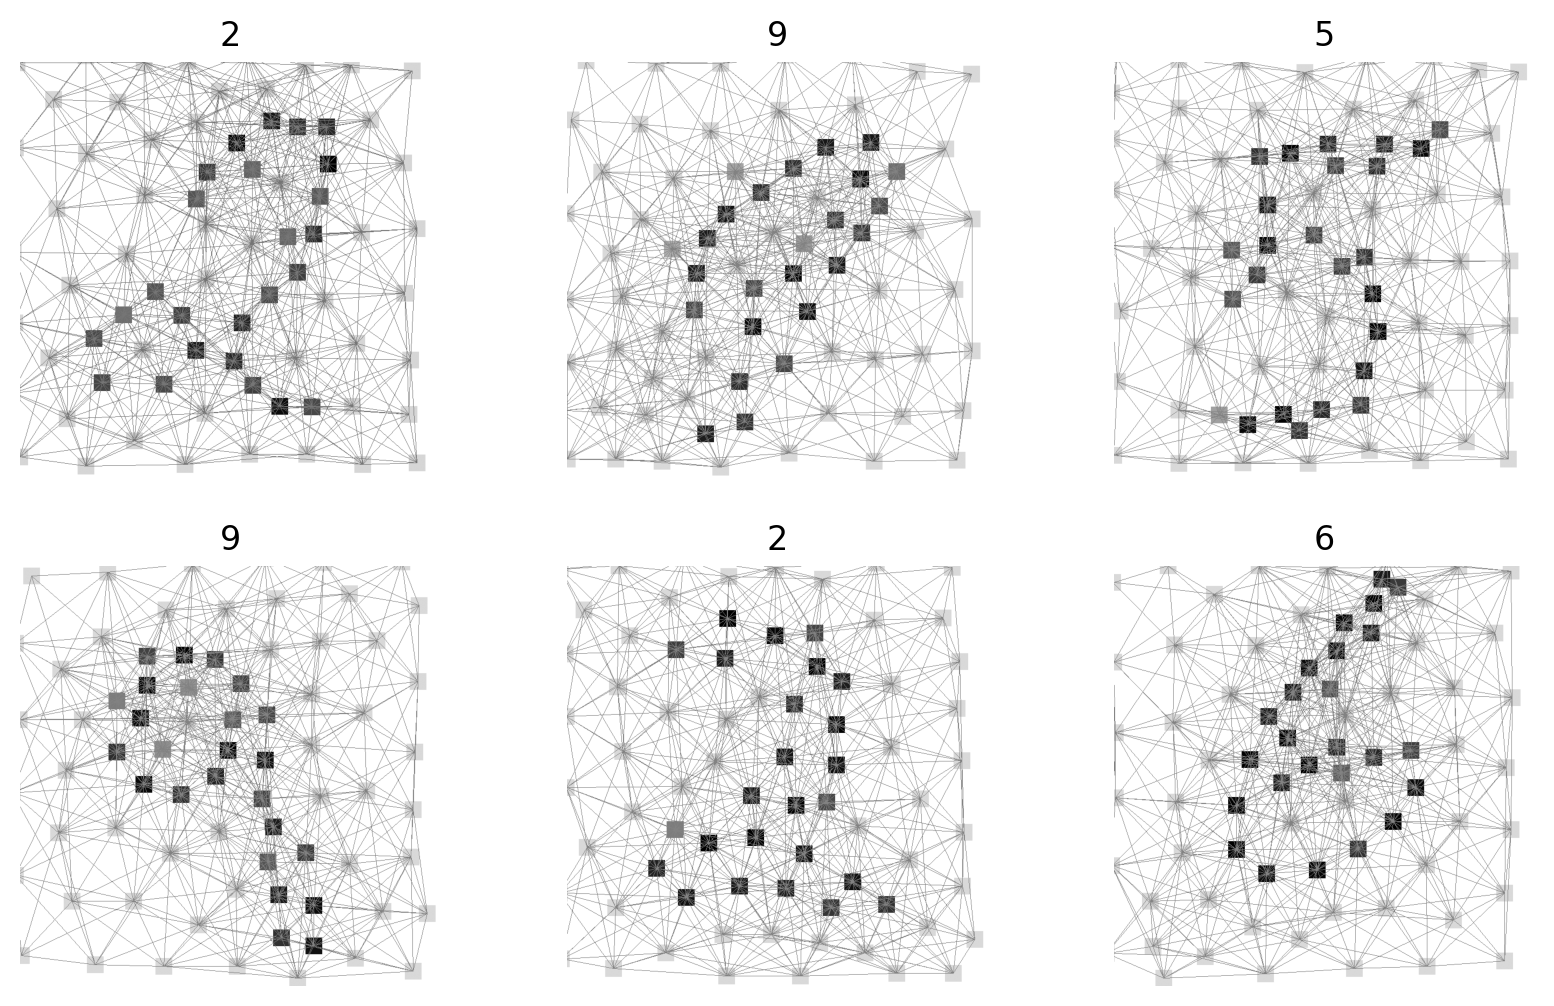

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6), dpi=200)
axes = axes.flatten()
data_loader_iter = iter(data_loader)
batch = next(data_loader_iter)
for i in range(len(axes)):
    image = superpixels_to_2d_image(batch[i])
    axes[i].imshow(image, cmap=plt.cm.binary)
    axes[i].axis("off")
    axes[i].set_title(f"{batch[i].y.item()}")
plt.show()

In [72]:
batch = next(data_loader_iter)
for g in batch[:]:
    adj = to_dense_adj((g.edge_index))
    assert torch.equal(g.edge_index, (dense_to_sparse(adj)[0]))

In [5]:
def generate_random_graph(n_nodes: int = 75, n_edge_feature: int = 2) -> Data:
    x: torch.Tensor = torch.rand((n_nodes, 1))
    edge_index: torch.Tensor = dense_to_sparse(torch.randint(0, 2, (n_nodes, n_nodes), dtype=torch.int64))[0]
    pos: torch.Tensor = torch.rand((n_nodes, 2)) * 28
    edge_attr: torch.Tensor = torch.rand((edge_index.shape[1], n_edge_feature))
    return Data(x=x, edge_index=edge_index, pos=pos, edge_attr=edge_attr, y=torch.Tensor(1))

# Generate graphs and concatenate batches

A random graph can be generated with the following function

Note that in this case the graph will be created on CPU.

In [95]:
def concat_batches(batches: list[Batch]) -> Batch:
    return Batch.from_data_list(
        list(itertools.chain(*[batch.to_data_list() for batch in batches]))
    )


test_batch: Batch = Batch.from_data_list(
    [
        generate_random_graph(),
        generate_random_graph(),
        generate_random_graph(),
    ]
)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Accelerator: {device}")
test_batch.to(device)
print(f"Batch is on: {test_batch.x.device}")

concatenated: Batch = concat_batches([test_batch]*4)
assert (test_batch.ptr.shape[0] - 1) * 4 == concatenated.ptr.shape[0] - 1

print(concatenated)
print(f"Concatenated batch is on: {concatenated.x.device}")

Accelerator: cuda:0
Batch is on: cuda:0
DataBatch(x=[900, 1], edge_index=[2, 33852], edge_attr=[33852, 2], y=[12], pos=[900, 2], batch=[900], ptr=[13])
Concatenated batch is on: cuda:0


# Simulation of concatenating a buffer

In [66]:
buffer: Batch = Batch.from_data_list(
    [generate_random_graph() for _ in range(10)]
)
print(buffer)
samples = Batch.from_data_list(random.choices(buffer, k=5))
print(samples)
concat_batches([buffer, samples])

DataBatch(x=[750, 1], edge_index=[2, 28054], edge_attr=[28054, 2], y=[10], pos=[750, 2], batch=[750], ptr=[11])
DataBatch(x=[375, 1], edge_index=[2, 14090], edge_attr=[14090, 2], y=[5], pos=[375, 2], batch=[375], ptr=[6])


DataBatch(x=[1125, 1], edge_index=[2, 42144], edge_attr=[42144, 2], y=[15], pos=[1125, 2], batch=[1125], ptr=[16])